# Leer datasets

In [16]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2)

adult = adult.data.features 
#drop null values
adult = adult.dropna()
#convert categorical variables to numerical
adult = pd.get_dummies(adult, drop_first=True, dtype=int)
print(adult.shape)
adult.head()

(47621, 100)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Realizamos los clusters

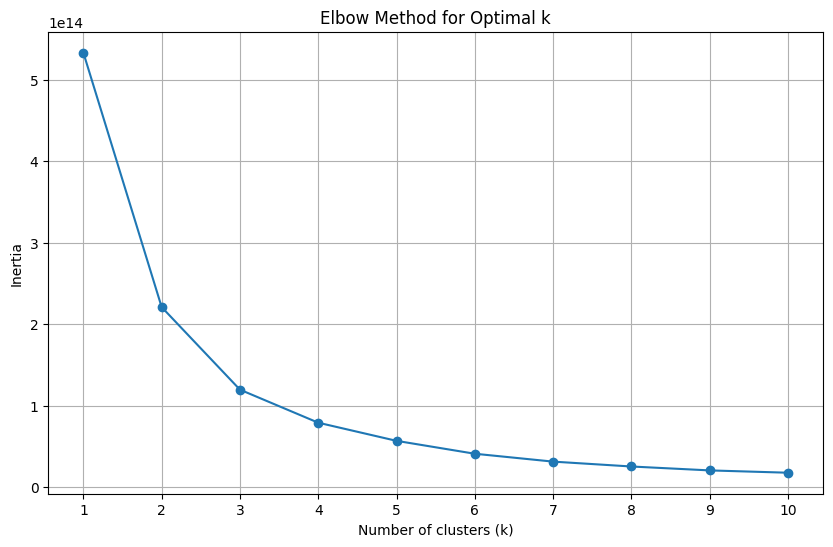

In [17]:
#hagamos metodo del codo para determinar el numero de clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(data, max_k=10):
    inertia = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid()
    plt.show()
# Aplicar el método del codo
elbow_method(adult)

In [28]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
#escalar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
adult_scaled = scaler.fit_transform(adult)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(adult_scaled)
kmeans_labels = kmeans.labels_
aglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
aglo.fit(adult_scaled)
aglo_labels = aglo.labels_
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(adult_scaled)
gmm_labels = gmm.predict(adult_scaled)

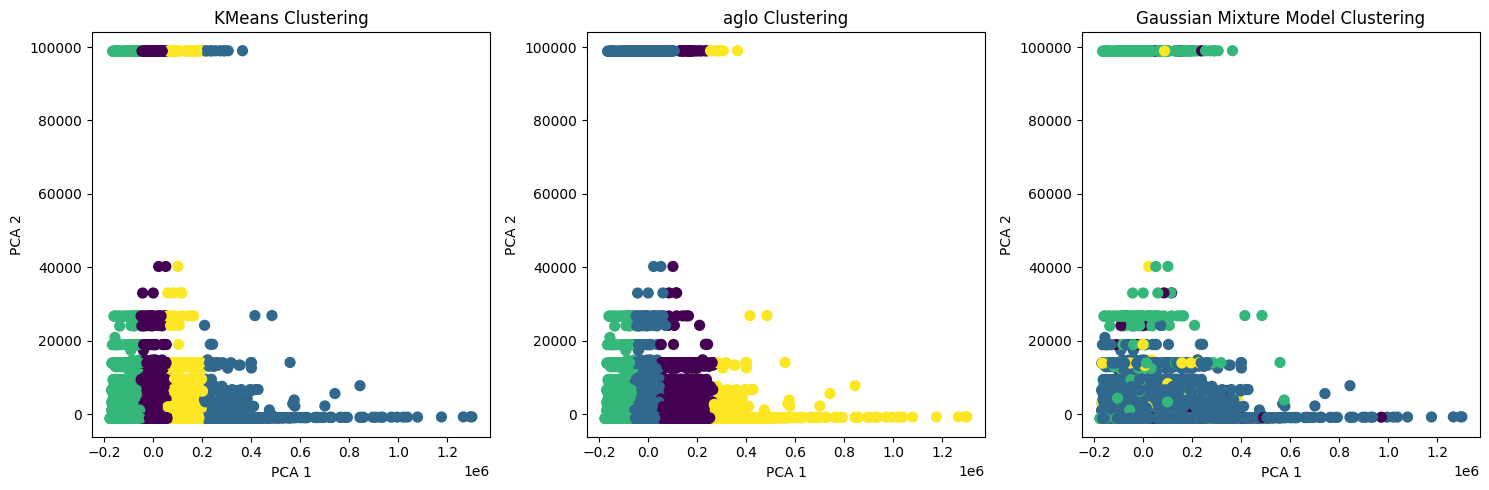

In [19]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Reducir a 2 dimensiones para visualización
pca = PCA(n_components=2)
adult_pca = pca.fit_transform(adult)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(adult_pca[:, 0], adult_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 2)
plt.scatter(adult_pca[:, 0], adult_pca[:, 1], c=aglo_labels, cmap='viridis', s=50)
plt.title('aglo Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 3)
plt.scatter(adult_pca[:, 0], adult_pca[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(adult, kmeans_labels)
aglo_silhouette = silhouette_score(adult, aglo_labels)
gmm_silhouette = silhouette_score(adult, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'aglo Silhouette Score: {aglo_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.55
aglo Silhouette Score: 0.54
Gaussian Mixture Model Silhouette Score: -0.13


# Interpretar

In [21]:
import sys
sys.path.append('..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [22]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(adult, kmeans_labels, test_size=0.2, random_state=42)


In [23]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [3.88525724e+01 1.88659490e+05 1.00879922e+01 1.07465393e+03
 9.20554421e+01 4.04614599e+01 2.38205795e-02 6.73291233e-02
 2.78603269e-04 7.22232541e-01 3.57540862e-02 7.51764487e-02
 3.70078009e-02 4.64338782e-04 3.67756315e-02 1.20728083e-02
 4.08618128e-03 9.75111441e-03 1.75520059e-02 1.49052749e-02
 3.39431649e-02 4.06296434e-02 1.62286404e-01 1.15156018e-02
 3.39153046e-01 5.55349183e-02 1.95022288e-03 1.77377415e-02
 2.13270802e-01 5.57206538e-04 4.60809807e-01 1.32800892e-02
 3.23829866e-01 3.21786776e-02 3.18536404e-02 1.20310178e-01
 4.17904903e-04 1.28157504e-01 1.24767831e-01 2.40527489e-02
 4.53658990e-02 7.05330609e-02 1.00761516e-01 5.38632987e-03
 1.26857355e-01 2.18703566e-02 1.17245542e-01 2.95319465e-02
 4.65267459e-02 2.51764487e-01 3.00427192e-02 1.58525260e-01
 1.05637073e-01 4.73161218e-02 2.28919019e-02 9.52358841e-02
 9.33320951e-03 8.66409733e-01 6.64236627e-01 2.78603269e-04
 3.71471025e-03 1.95022288e-03 2.55386330e-03 3.34

In [24]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.91


In [25]:
r = ripper.get_rules()
string = str(r[0])
string1 = str(r[1])
rules = string.split('V')
rules1 = string1.split('V')
print("aglo Ripper Rules:", len(rules))
print("aglo Ripper Rules:", len(rules1))
ripper.print_rules()

aglo Ripper Rules: 11
aglo Ripper Rules: 43

Reglas para clase: 0
[[fnlwgt=158177.0-178037.0] V [fnlwgt=178037.0-196385.0] V [fnlwgt=196385.0-220318.5] V [fnlwgt=130844.5-158177.0^marital-status_Never-married=0^age=41.0-45.0^hours-per-week=>55.0] V [fnlwgt=130844.5-158177.0] V [fnlwgt=220318.5-260093.0^education_HS-grad=1^relationship_Not-in-family=0^occupation_Transport-moving=0^sex_Male=1^age=33.0-37.0^native-country_Italy=0^hours-per-week=35.0-40.0] V [fnlwgt=220318.5-260093.0^education-num=7.0-9.0] V [fnlwgt=220318.5-260093.0^education-num=11.0-13.0^sex_Male=1^marital-status_Never-married=1^occupation_Prof-specialty=1^relationship_Own-child=0] V [fnlwgt=220318.5-260093.0^hours-per-week=40.0-50.0^relationship_Not-in-family=0^race_White=1^age=41.0-45.0^education_Some-college=0] V [fnlwgt=220318.5-260093.0^relationship_Own-child=1^education_Some-college=0] V [fnlwgt=220318.5-260093.0]]

Reglas para clase: 1
[[fnlwgt=>327893.5^race_Black=1^workclass_Private=0] V [fnlwgt=>327893.5^race_

Decision Tree Accuracy: 1.00


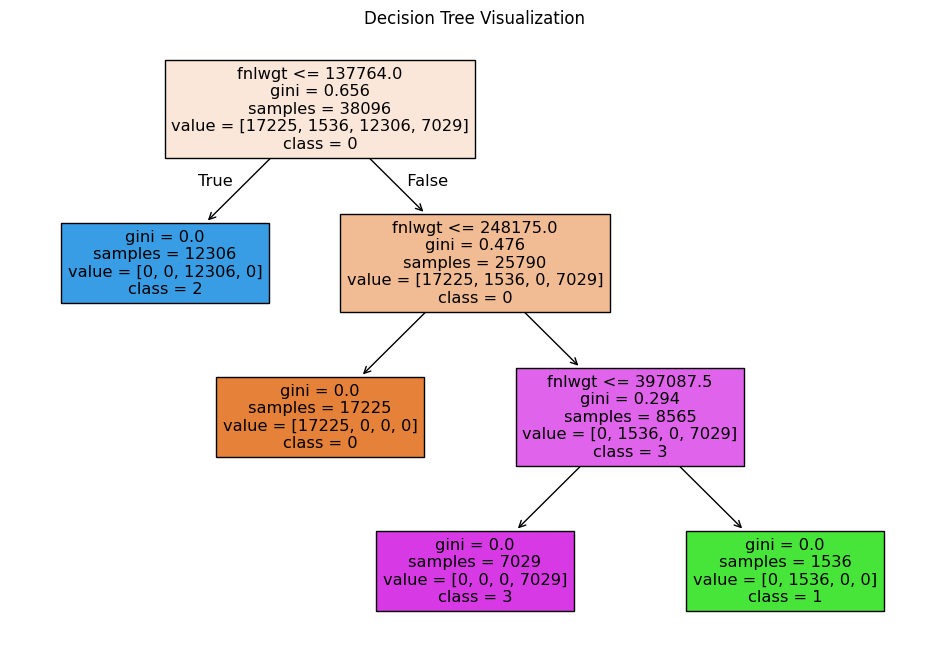

In [26]:
tree = DecisionTreeClassifier(random_state=44, max_depth=5, min_samples_split=10)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=adult.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [27]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=adult.columns.tolist())


Optimization started


KeyboardInterrupt: 

In [ ]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.855] R14: chol < 213.187
			0: 0.855	1: 0.000	2: 0.000	Unc: 0.145

	[0.492] R32: oldpeak > 1.803
			0: 0.469	1: 0.046	2: 0.000	Unc: 0.485

	[0.430] R23: thalach < 132.845
			0: 0.376	1: 0.000	2: 0.117	Unc: 0.507

	[0.430] R21: restecg = 1.0
			0: 0.221	1: 0.618	2: 0.000	Unc: 0.162

	[0.363] R8: cp = 3.0
			0: 0.266	1: 0.042	2: 0.189	Unc: 0.504

	[0.324] R10: trestbps < 120.113
			0: 0.268	1: 0.039	2: 0.087	Unc: 0.607

	[0.322] R41: thal = 6.0
			0: 0.280	1: 0.088	2: 0.001	Unc: 0.631

Most important rules for class 1

	[0.892] R17: chol > 283.733
			0: 0.000	1: 0.892	2: 0.000	Unc: 0.108

	[0.720] R21: restecg = 1.0
			0: 0.221	1: 0.618	2: 0.000	Unc: 0.162

	[0.569] R39: ca = 3.0
			0: 0.013	1: 0.537	2: 0.054	Unc: 0.397

	[0.349] R42: thal = 7.0
			0: 0.006	1: 0.291	2: 0.120	Unc: 0.582

	[0.325] R4: sex = 0.0
			0: 0.028	1: 0.298	2: 0.030	Unc: 0.645

Most important rules for class 2

	[0.851] R16: 248.460 < chol < 283.733
			0: 0.000	1: 0.000	2: 0.

In [ ]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.92


## aglo

In [ ]:
#dividir los datos en entrenamiento y prueba
n_clusters_aglo = len(np.unique(aglo_labels))
max_label = np.max(aglo_labels)
aglo_labels = np.where(aglo_labels == -1, max_label + 1, aglo_labels)  # Assign a new label for noise points
X_train, X_test, y_train, y_test = train_test_split(adult, aglo_labels, test_size=0.2, random_state=42)


In [ ]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.90


In [ ]:
r = ripper.get_rules()
string = str(r[0])
string1 = str(r[1])
rules = string.split('V')
rules1 = string1.split('V')
print("aglo Ripper Rules:", len(rules))
print("aglo Ripper Rules:", len(rules1))
ripper.print_rules()

aglo Ripper Rules: 3
aglo Ripper Rules: 10

Reglas para clase: 0
[[chol=>308.4] V [chol=285.6-308.4] V [chol=269.0-285.6^cp=1]]

Reglas para clase: 1
[[chol=256.6-269.0] V [chol=244.0-256.6] V [chol=269.0-285.6^thalach=<114.6] V [chol=269.0-285.6^age=45.0-49.8] V [chol=233.0-244.0^age=56.0-58.0] V [trestbps=<110.0^chol=221.6-233.0] V [thalach=>174.0^oldpeak=0.3-0.8] V [trestbps=>152.8^chol=269.0-285.6] V [chol=233.0-244.0^trestbps=110.0-120.0] V [chol=285.6-308.4^fbs=1^cp=4]]

Reglas para clase: 2
[[chol=206.2-221.6] V [chol=192.6-206.2] V [chol=<192.6] V [chol=221.6-233.0^restecg=2] V [chol=221.6-233.0^sex=0] V [chol=233.0-244.0^trestbps=135.0-140.0] V [trestbps=145.8-152.8^chol=233.0-244.0] V [chol=221.6-233.0^cp=3^exang=0]]


Decision Tree Accuracy: 0.95


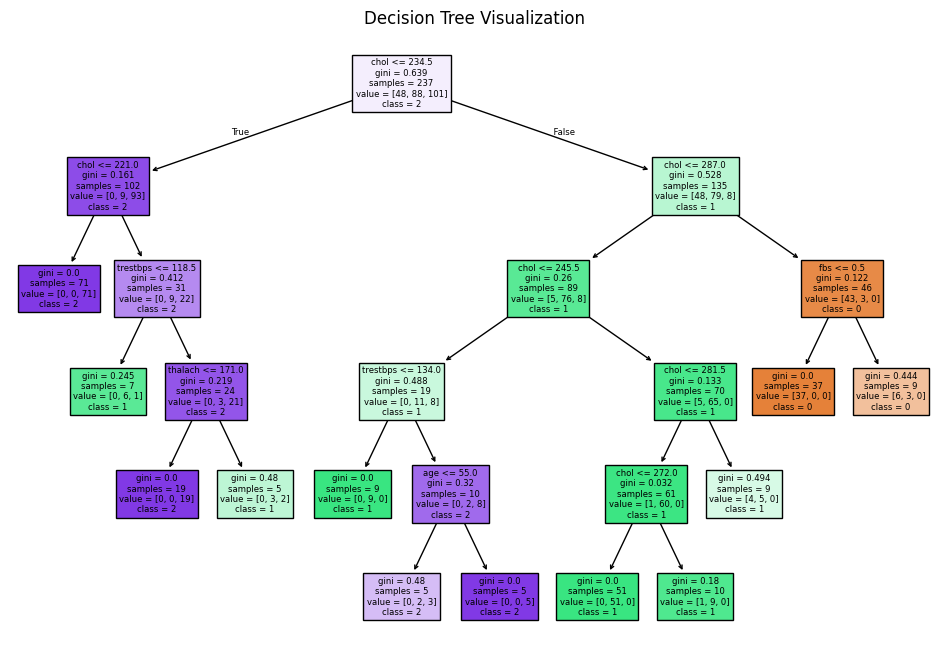

In [ ]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5, min_samples_split=10, max_depth=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=adult.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [ ]:
ds = DSClassifierMultiQ(n_clusters_aglo, min_iter=20, max_iter=400, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=adult.columns.tolist())


Optimization started

Training time: 15.15s, epochs: 329

Least training loss reached: 0.029


In [ ]:
ds.print_most_important_rules()



Most important rules for class 0

	[0.987] R17: chol > 283.733
			0: 0.976	1: 0.023	2: 0.000	Unc: 0.001

	[0.959] R6: cp = 1.0
			0: 0.929	1: 0.000	2: 0.059	Unc: 0.011

	[0.888] R21: restecg = 1.0
			0: 0.888	1: 0.000	2: 0.000	Unc: 0.112

	[0.659] R41: thal = 6.0
			0: 0.475	1: 0.000	2: 0.441	Unc: 0.084

	[0.547] R12: 132.253 < trestbps < 144.393
			0: 0.417	1: 0.000	2: 0.301	Unc: 0.283

	[0.519] R25: 148.481 < thalach < 164.117
			0: 0.479	1: 0.000	2: 0.085	Unc: 0.436

	[0.503] R11: 120.113 < trestbps < 132.253
			0: 0.404	1: 0.000	2: 0.223	Unc: 0.373

	[0.493] R3: age > 60.658
			0: 0.311	1: 0.000	2: 0.470	Unc: 0.218

	[0.473] R26: thalach > 164.117
			0: 0.328	1: 0.357	2: 0.000	Unc: 0.316

	[0.465] R42: thal = 7.0
			0: 0.380	1: 0.000	2: 0.189	Unc: 0.431

	[0.400] R36: ca = 0.0
			0: 0.281	1: 0.000	2: 0.289	Unc: 0.430

	[0.357] R30: 0.273 < oldpeak < 1.038
			0: 0.202	1: 0.431	2: 0.000	Unc: 0.367

	[0.349] R33: slope = 1.0
			0: 0.325	1: 0.000	2: 0.049	Unc: 0.626

	[0.343] R9: cp 

In [ ]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.85


## GMM

In [ ]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(adult, gmm_labels, test_size=0.2, random_state=42)


In [ ]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.98


In [ ]:
r = ripper.get_rules()
string = str(r[0])
string1 = str(r[1])
rules = string.split('V')
rules1 = string1.split('V')
print("aglo Ripper Rules:", len(rules))
print("aglo Ripper Rules:", len(rules1))
ripper.print_rules()

aglo Ripper Rules: 1
aglo Ripper Rules: 1

Reglas para clase: 0
[[fbs=0]]

Reglas para clase: 1
[[fbs=1^cp=4]]

Reglas para clase: 2
[[fbs=1^ca=0.0] V [fbs=1^thal=3.0]]


Decision Tree Accuracy: 0.97


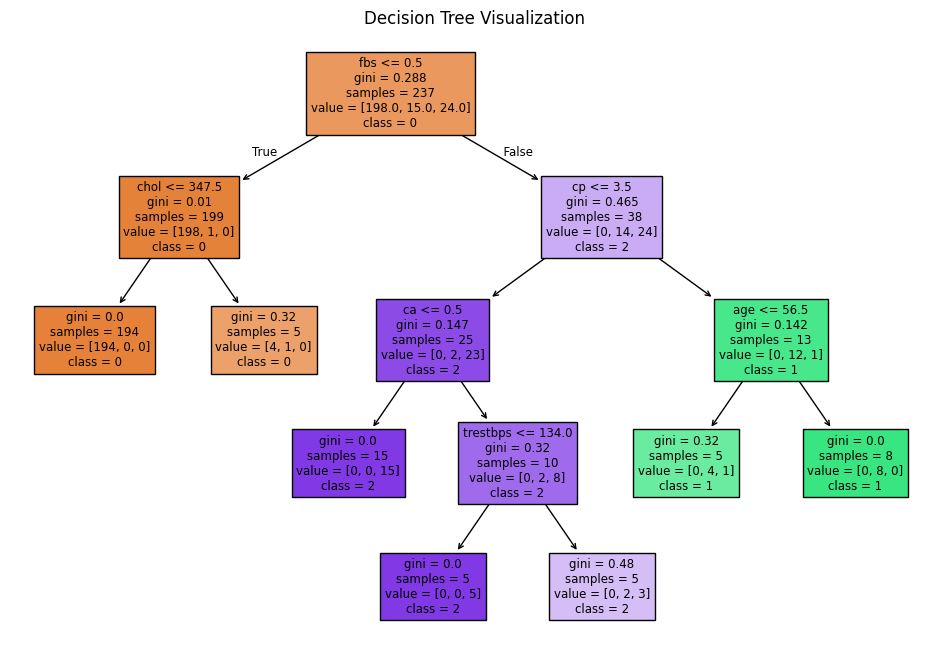

In [ ]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5, min_samples_split=10, max_depth=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=adult.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [ ]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=adult.columns.tolist())


Optimization started

Training time: 9.06s, epochs: 200

Least training loss reached: 0.009


In [ ]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.566] R6: cp = 1.0
			0: 0.342	1: 0.000	2: 0.594	Unc: 0.063

	[0.547] R7: cp = 2.0
			0: 0.326	1: 0.000	2: 0.593	Unc: 0.081

	[0.479] R32: oldpeak > 1.803
			0: 0.432	1: 0.100	2: 0.000	Unc: 0.468

	[0.462] R1: 48.566 < age < 54.612
			0: 0.351	1: 0.000	2: 0.258	Unc: 0.391

	[0.451] R39: ca = 3.0
			0: 0.260	1: 0.524	2: 0.000	Unc: 0.216

	[0.411] R18: fbs = 0.0
			0: 0.411	1: 0.000	2: 0.000	Unc: 0.589

	[0.402] R38: ca = 2.0
			0: 0.219	1: 0.517	2: 0.000	Unc: 0.264

	[0.397] R21: restecg = 1.0
			0: 0.397	1: 0.000	2: 0.000	Unc: 0.603

	[0.396] R40: thal = 3.0
			0: 0.299	1: 0.000	2: 0.226	Unc: 0.476

	[0.392] R36: ca = 0.0
			0: 0.335	1: 0.000	2: 0.124	Unc: 0.541

	[0.389] R16: 248.460 < chol < 283.733
			0: 0.308	1: 0.000	2: 0.185	Unc: 0.508

	[0.388] R8: cp = 3.0
			0: 0.217	1: 0.000	2: 0.478	Unc: 0.305

	[0.379] R9: cp = 4.0
			0: 0.292	1: 0.198	2: 0.000	Unc: 0.510

	[0.370] R20: restecg = 0.0
			0: 0.368	1: 0.004	2: 0.000	Unc: 0.628

	[0.359] R

In [ ]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 1.00
